In [3]:
HOME_DIR =       "./"
DATA_DIR =       "./PROSTATEx_masks/Files/prostate/"
OUT_DIR =        "./aug_results/prostate/"
SLICED_OUT_DIR = "./data/sliced/prostate/"
AUG_OUT_DIR = "./data/augmented_test/prostate/"

In [4]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
import pandas as pd


import json
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os

from monai.utils import first

In [9]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [34]:
data = get_data_path(SLICED_OUT_DIR)

In [5]:
import torch
import nibabel as nib

import elasticdeform 
from skimage.util import random_noise
import scipy
from scipy.ndimage import affine_transform

import torchvision.transforms.functional as TF
import nibabel as nib
#import torchio as tio

import numpy as np
from scipy import ndimage
from scipy.ndimage import shift
import random

In [10]:
def hFlipRotate(image, label):
    angle =  random.uniform(-5, 5)
    imgvol = np.array( image.dataobj )
    lblvol = np.array( label.dataobj )

    # horizontal flip
    img = np.fliplr(imgvol)
    lbl = np.fliplr(lblvol)
    
    #Rotate
    img = ndimage.rotate(img, angle, reshape=False)
    lbl = ndimage.rotate(lbl, angle, reshape=False)
    
    image = nib.Nifti1Image ( img, image.affine )
    label = nib.Nifti1Image ( lbl, label.affine )
    return image, label

In [421]:
def hFlipRotateZoom(image, label):
    angle = random.uniform(-5, 5)
    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # horizontal flip
    img = np.fliplr(img)
    lbl = np.fliplr(lbl)

    # zoom
    zoom_factor = random.uniform(0.8, 1.2)
    zoomed_img = ndimage.zoom(img, zoom_factor, order=1)
    zoomed_lbl = ndimage.zoom(lbl, zoom_factor, order=0)

    image = nib.Nifti1Image(zoomed_img, image.affine)
    label = nib.Nifti1Image(zoomed_lbl, label.affine)
    return image, label

In [65]:
import scipy

def hFlipShear(image, label):
    angle = random.uniform(-5, 5)
    shear = random.uniform(-0.2,0.2)

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # horizontal flip
    img = np.fliplr(imgvol)
    lbl = np.fliplr(lblvol)

    # apply shear transformation
    matrix = np.array([[1, shear, 0], [0, 1, 0], [0, 0, 1]])
    img = scipy.ndimage.affine_transform(img, matrix)
    lbl = scipy.ndimage.affine_transform(lbl, matrix)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label


In [404]:
def random_flip_rotate_noise(image, label):
    angle = random.uniform(-5, 5)
    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Randomly flip the image and label along one or more axes
    flip_axes = tuple(np.random.choice([-1, 1], size=image.ndim, replace=True))
    img = np.flip(imgvol, axis=flip_axes)
    lbl = np.flip(lblvol, axis=flip_axes)

    # Rotate
    img = ndimage.rotate(img, angle, reshape=False)
    lbl = ndimage.rotate(lbl, angle, reshape=False)

    # Add noise
    # Gaussian noise
    img = random_noise(img, mode='gaussian', var=0.000001, clip=False)
    # Salt & Pepper noise
    img = random_noise(img, mode='s&p', salt_vs_pepper=0.5, amount=0.0000005, clip=False)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label


In [19]:
import scipy
from scipy.ndimage import affine_transform

def hFlipShearTrans(image, label):
    angle = random.uniform(-5, 5)
    shear = random.uniform(-0.2,0.2)
    translate = (random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10))

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # horizontal flip
    img = np.fliplr(imgvol)
    lbl = np.fliplr(lblvol)

    # apply shear transformation
    matrix = np.array([[1, shear, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1, translate[2]], [0, 0, 0, 1]])
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label

In [416]:
def hFlipRotateNoise(image, label):
    angle =  random.uniform(-5, 5)
    imgvol = np.array( image.dataobj )
    lblvol = np.array( label.dataobj )

    # horizontal flip
    img = np.fliplr(imgvol)
    lbl = np.fliplr(lblvol)
    
    # Rotate
    img = ndimage.rotate(img, angle, reshape=False)
    lbl = ndimage.rotate(lbl, angle, reshape=False)
    
    # Noise
    # # Gaussian noise
    # img = random_noise(imgvol, mode='gaussian', var=0.0000001, clip=False)
    # # Salt & Pepper noise
    # img = random_noise(img, mode='s&p',salt_vs_pepper=0.5, amount=0.00000005, clip=False)


    
    image = nib.Nifti1Image ( img, image.affine )
    label = nib.Nifti1Image ( lblvol, label.affine )
    return image, label

In [499]:
def random_flip_rotate_zoom_translate(image, label):
    angle = random.uniform(-5, 5)
    flip_axes = [ i for i in range(2) if i!=2 and np.random.choice([0, 1]) == 1]
    translate = (random.uniform(-10,10), random.uniform(-10,10))
    matrix = np.array([[1, 0, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1,  0], [0, 0, 0, 1]])

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(img, axis=flip_axes)
    lbl = np.flip(lbl, axis=flip_axes)

    # zoom
    zoom_factor = random.uniform(0.8, 1.2)
    img = ndimage.zoom(img, zoom_factor, order=1)
    lbl = ndimage.zoom(lbl, zoom_factor, order=0)

    # Translate
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label


In [502]:
def random_flip_rotate_zoom_shear_translate(image, label):
    
    angle = random.uniform(-5, 5)
    flip_axes = [ i for i in range(2) if i!=2 and np.random.choice([0, 1]) == 1]
    translate = (random.uniform(-10,10), random.uniform(-10,10))
    shear = random.uniform(-0.2,0.2)
    matrix = np.array([[1, shear, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1, 0], [0, 0, 0, 1]])
    

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(img, axis=flip_axes)
    lbl = np.flip(lbl, axis=flip_axes)

    # zoom
    zoom_factor = random.uniform(0.8, 1.2)
    img = ndimage.zoom(img, zoom_factor, order=1)
    lbl = ndimage.zoom(lbl, zoom_factor, order=0)

    # Translate
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label


In [ ]:
def random_flip_rotate_translate_deform(image, label):
    angle = random.uniform(-5, 5)
    flip_axes = [ i for i in range(2) if i!=2 and np.random.choice([0, 1]) == 1]
    sigma = random.choice([2, 3])
    translate = (random.uniform(-10,10), random.uniform(-10,10))
    matrix = np.array([[1, 0, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1,  0], [0, 0, 0, 1]])

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(img, axis=flip_axes)
    lbl = np.flip(lbl, axis=flip_axes)

    # zoom
    zoom_factor = random.uniform(0.8, 1.2)
    img = ndimage.zoom(img, zoom_factor, order=1)
    lbl = ndimage.zoom(lbl, zoom_factor, order=0)

    # Elastic deformation
    [img, lbl] = elasticdeform.deform_random_grid([img, lbl], sigma=sigma, axis=[(0, 1), (0, 1)], order=[1, 0], mode='constant')
    


    # Translate
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label


In [31]:
import random
import numpy as np
import nibabel as nib
from scipy import ndimage
from skimage.exposure import adjust_gamma, rescale_intensity

def random_flip_rotate_zoom_translate_brightness(image, label):
    angle = random.uniform(-5, 5)
    flip_axes = [i for i in range(2) if i != 2 and np.random.choice([0, 1]) == 1]
    translate = (random.uniform(-10, 10), random.uniform(-10, 10))
    matrix = np.array([[1, 0, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1, 0], [0, 0, 0, 1]])

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(img, axis=flip_axes)
    lbl = np.flip(lbl, axis=flip_axes)

    # Zoom
    zoom_factor = random.uniform(0.8, 1.2)
    img = ndimage.zoom(img, zoom_factor, order=1)
    lbl = ndimage.zoom(lbl, zoom_factor, order=0)

    # Translate
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    # Brightness
    gamma = random.uniform(0.8, 1.2)
    min_value = np.min(img)
    img = img - min_value
    img = adjust_gamma(img, gamma)

    # Contrast
    low = np.percentile(img, 10)
    high = np.percentile(img, 98)
    img = rescale_intensity(img, in_range=(low, high))

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label


In [10]:
import scipy
from scipy.ndimage import affine_transform

def hFlipRotateShearTrans(image, label):
    angle = random.uniform(-5, 5)
    shear = random.uniform(-0.2,0.2)
    translate = (random.uniform(-10,10), random.uniform(-10,10))

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # horizontal flip
    img = np.fliplr(img)
    lbl = np.fliplr(lbl)


    # apply shear transformation
    matrix = np.array([[1, shear, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1, 0], [0, 0, 0, 1]])
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label

In [160]:
import numpy as np
import nibabel as nib
import random
import elasticdeform
from scipy import ndimage

def hFlipRotateTranslateElasticDeform(image, label):
    angle = random.uniform(-5, 5)
    shear = random.uniform(-0.2,0.2)
    translate = (random.uniform(-10,10), random.uniform(-10,10))

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = ndimage.rotate(imgvol, angle, reshape=False)
    lbl = ndimage.rotate(lblvol, angle, reshape=False)

    # horizontal flip
    img = np.fliplr(img)
    lbl = np.fliplr(lbl)


    # apply shear transformation
    matrix = np.array([[1, shear, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1, 0], [0, 0, 0, 1]])
    img = affine_transform(img, matrix, order=1)
    lbl = affine_transform(lbl, matrix, order=0)

    # Elastic deformation
    sigma = random.choice([2, 3])
    print(sigma)
    # img_deformed = elasticdeform.deform_random_grid(img, sigma=sigma, order=3, axis=(0, 1, 2))
    # lbl_deformed = elasticdeform.deform_random_grid(lbl, sigma=sigma, order=0, axis=(0, 1, 2))
    [img_deformed, lbl_deformed] = elasticdeform.deform_random_grid([img, lbl], sigma=sigma, axis=[(0, 1), (0, 1)], order=[1, 0], mode='constant')
    

    image = nib.Nifti1Image(img_deformed, image.affine)
    label = nib.Nifti1Image(lbl_deformed, label.affine)
    return image, label


In [24]:
from Augmentation.augmentation import changeContrast, vFlipRotate, hFlipRotate

In [40]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"])
labela =nib.load(data[0]["label"])

imagea, labela = imagea.get_fdata(), labela.get_fdata()

In [32]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"])
labela =nib.load(data[0]["label"])
print(imagea.shape,labela.shape)
imagea, labela = random_flip_rotate_zoom_translate_brightness(imagea, labela)
imagea, labela = imagea.get_fdata(), labela.get_fdata()

(384, 384, 16) (384, 384, 16)


In [33]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(imagea[:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off');

    ax[1].imshow(labela[:,:,layer])
    ax[1].axis('off');
    return layer

In [34]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 15))

interactive(children=(IntSlider(value=7, description='layer', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

In [16]:
# first image, label from orignal image
image =nib.load(data[0]["image"])
label =nib.load(data[0]["label"])

image, label = image.get_fdata(), label.get_fdata()

In [17]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(image[:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off')

    ax[1].imshow(label[:,:,layer])
    ax[1].axis('off')
    return layer

In [18]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 15))

interactive(children=(IntSlider(value=7, description='layer', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

In [35]:
data = data[:16]

In [56]:
import nibabel as nib
import random
import elasticdeform 
import numpy as np
import nibabel as nib

from scipy.ndimage import affine_transform, rotate, zoom
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.util import random_noise


def random_flip_rotate_zoom(image, label):
    angle = random.uniform(-5, 5)
    flip_axes = [ i for i in range(2) if i!=2 and np.random.choice([0, 1]) == 1]
    translate = (random.uniform(-10,10), random.uniform(-10,10))
    matrix = np.array([[1, 0, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1,  0], [0, 0, 0, 1]])

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)

    # Rotate
    img = rotate(imgvol, angle, reshape=False)
    lbl = rotate(lblvol, angle, reshape=False)

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(img, axis=flip_axes)
    lbl = np.flip(lbl, axis=flip_axes)

    # zoom
    zoom_factor = random.uniform(0.8, 1.2)
    img = zoom(img, zoom_factor, order=1)
    lbl = zoom(lbl, zoom_factor, order=0)

    # # Translate
    # img = affine_transform(img, matrix, order=1)
    # lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, label

In [192]:
from Augmentation.augmentation import rotate

In [80]:
from Augmentation.combine_augmentation import random_flip_rotate_zoom_translate, random_flip_rotate_zoom_shear_translate, random_flip_rotate_translate_deform, random_flip_rotate_zoom_translate_brightness, random_flip_rotate_noise

In [214]:
data = get_data_path(SLICED_OUT_DIR)
data = data[:16]

In [211]:
types = {  'FRZT' :  random_flip_rotate_zoom_translate, 'FRTD': random_flip_rotate_translate_deform  }

for type,func in types.items():
    # create directries if does not exist
    if not os.path.exists(AUG_OUT_DIR + type ):
        os.makedirs(AUG_OUT_DIR + type)
    if not os.path.exists(AUG_OUT_DIR + type + "/Images"):
        os.makedirs(AUG_OUT_DIR + type + "/Images")
    if not os.path.exists(AUG_OUT_DIR + type + "/mask_prostate"):
        os.makedirs(AUG_OUT_DIR + type + "/mask_prostate")

In [212]:
from utils.preprocessing import load_nifti

def augment(func, entry, name, paths):
    img, lbl = load_nifti(entry["image"], entry["label"])
    
    image, label = func(img, lbl)
    image_path = entry["image"].replace("data/sliced/prostate", "data/augmented_test/prostate/" + name)
    label_path = entry["label"].replace("data/sliced/prostate", "data/augmented_test/prostate/" + name)
    paths.append({"image":image_path, "label":label_path})
    image.to_filename(image_path )
    label.to_filename(label_path)
    

In [210]:
len(data)

16

In [215]:
from utils.preprocessing import save_to_json

paths = []
for type, func in types.items():
    #create augmented data
    
    for entry in data:
        augment(func, entry, type, paths)
        
   
save_to_json({"path": paths}, AUG_OUT_DIR + '/config.json')    


TypeError: rotate() got an unexpected keyword argument 'reshape'

# Transform

In [156]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [181]:
data = data[:16]
aug_data = get_data_path(AUG_OUT_DIR)


train_size = int(0.8 * len(data))
train_data = data[:train_size] + aug_data[:train_size]
test_data = data[train_size:]+ data[train_size:]

In [184]:
len(train_data)

24

In [182]:
pixdim =(1.5, 1.5, 1.0)
a_min=0
a_max=500
spatial_size= [128, 128,16] #[384, 384,18]


In [183]:
from utils.transform import transform

train_loader = transform(train_data, a_min, a_max, spatial_size, pixdim)
test_loader = transform(test_data, a_min, a_max, spatial_size, pixdim)

In [143]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
from utils.train import train

In [185]:
model_dir = OUT_DIR 
data_in = [train_loader, test_loader]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [186]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=( 64, 128, 256,512), 
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [187]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [71]:
# model_dir = OUT_DIR + "unet/"
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

In [188]:
train(unet, data_in, loss_function, optimizer, 40, model_dir, test_interval=5,start_from=1)

----------
epoch 1/40
1/24, Train_loss: 0.9110 Train_dice: 0.0890
2/24, Train_loss: 0.9315 Train_dice: 0.0685
3/24, Train_loss: 0.9382 Train_dice: 0.0618
4/24, Train_loss: 0.7820 Train_dice: 0.2180
5/24, Train_loss: 0.8133 Train_dice: 0.1867
6/24, Train_loss: 0.9197 Train_dice: 0.0803
7/24, Train_loss: 0.8732 Train_dice: 0.1268
8/24, Train_loss: 0.8417 Train_dice: 0.1583
9/24, Train_loss: 0.8825 Train_dice: 0.1175
10/24, Train_loss: 0.8550 Train_dice: 0.1450
11/24, Train_loss: 0.9196 Train_dice: 0.0804
12/24, Train_loss: 0.9276 Train_dice: 0.0724
13/24, Train_loss: 0.5461 Train_dice: 0.4539
14/24, Train_loss: 0.9188 Train_dice: 0.0812
15/24, Train_loss: 0.9201 Train_dice: 0.0799
16/24, Train_loss: 0.4110 Train_dice: 0.5890
17/24, Train_loss: 0.7883 Train_dice: 0.2117
18/24, Train_loss: 0.5746 Train_dice: 0.4254
19/24, Train_loss: 0.5175 Train_dice: 0.4825
20/24, Train_loss: 0.4685 Train_dice: 0.5315
21/24, Train_loss: 0.5025 Train_dice: 0.4975
22/24, Train_loss: 0.4786 Train_dice: 0.52

In [ ]:
from monai.utils import first
from monai.transforms import(
    Activations,
)

import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

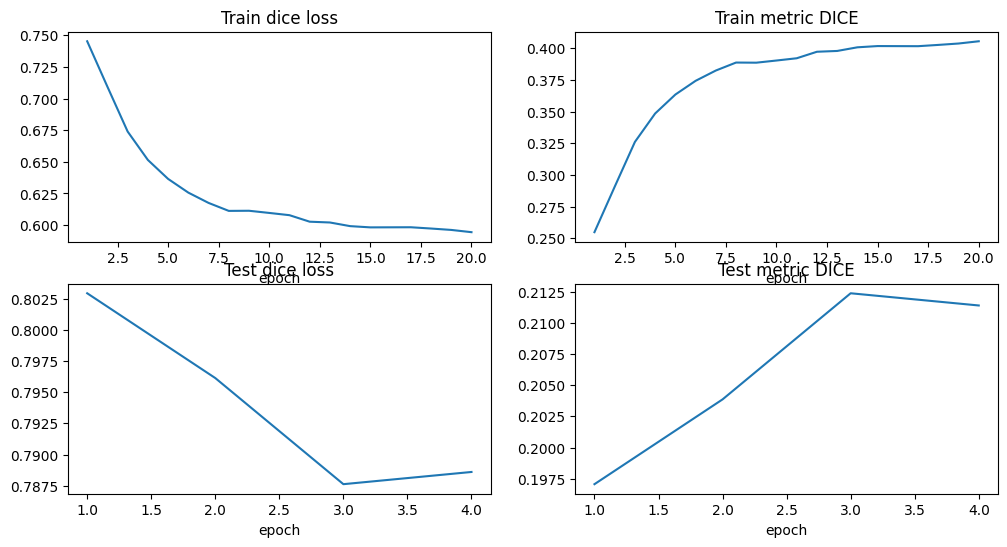

In [178]:
from utils.view import  plt_metrices

path = OUT_DIR
if (os.path.exists(path)):
    plt_metrices(path)